<a href="https://colab.research.google.com/github/Strikoder/DS-ML-DL/blob/main/Home_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and initilizations 

In [1]:
! pip install kaggle 
from google.colab import drive
drive.mount('/content/drive')

#Importing data from kaggle settings
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download house-prices-advanced-regression-techniques
! unzip house-prices-advanced-regression-techniques.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
#Libraries - basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #Heatmap

#Scikitlearn
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

#ANN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

import pickle
pd.set_option('display.max_rows', None)

# Data preprocessing

In [3]:
test_df=pd.read_csv('test.csv')

In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


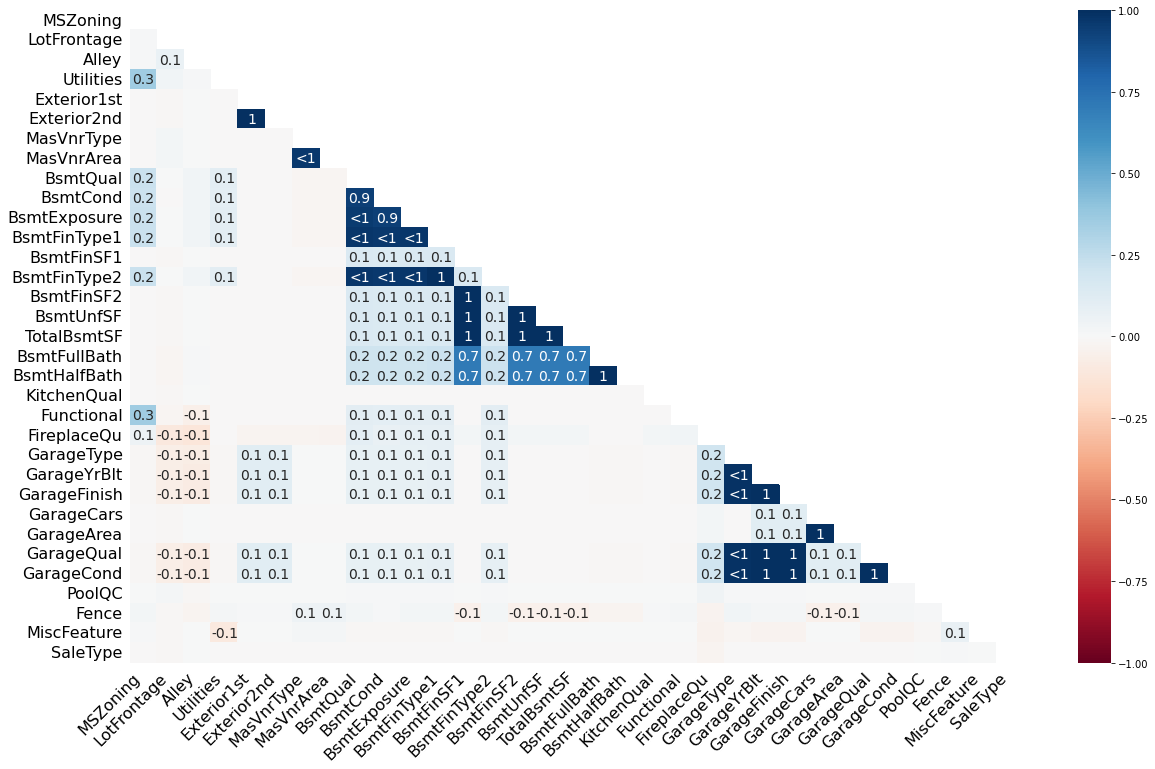

In [5]:
msno.heatmap(test_df) #corrlations

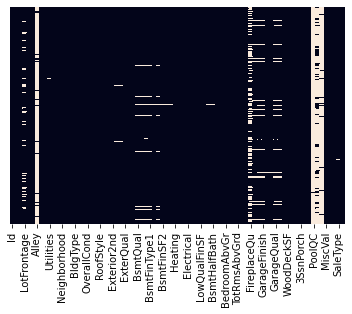

In [6]:
sns.heatmap(test_df.isnull(),yticklabels=False,cbar=False)

In [7]:
test_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [8]:
## Fill Missing Values
test_df['LotFrontage']=test_df['LotFrontage'].fillna(test_df['LotFrontage'].mean())
test_df['MSZoning']=test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])
test_df.drop(['Alley'],axis=1,inplace=True)
test_df['BsmtCond']=test_df['BsmtCond'].fillna(test_df['BsmtCond'].mode()[0])
test_df['BsmtQual']=test_df['BsmtQual'].fillna(test_df['BsmtQual'].mode()[0])
test_df['FireplaceQu']=test_df['FireplaceQu'].fillna(test_df['FireplaceQu'].mode()[0])
test_df['GarageType']=test_df['GarageType'].fillna(test_df['GarageType'].mode()[0])
test_df.drop(['GarageYrBlt'],axis=1,inplace=True)
test_df['GarageFinish']=test_df['GarageFinish'].fillna(test_df['GarageFinish'].mode()[0])
test_df['GarageQual']=test_df['GarageQual'].fillna(test_df['GarageQual'].mode()[0])
test_df['GarageCond']=test_df['GarageCond'].fillna(test_df['GarageCond'].mode()[0])
test_df.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
test_df.drop(['Id'],axis=1,inplace=True)
test_df['MasVnrType']=test_df['MasVnrType'].fillna(test_df['MasVnrType'].mode()[0])
test_df['MasVnrArea']=test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].mode()[0])
test_df['BsmtExposure']=test_df['BsmtExposure'].fillna(test_df['BsmtExposure'].mode()[0])
test_df['BsmtFinType2']=test_df['BsmtFinType2'].fillna(test_df['BsmtFinType2'].mode()[0])
test_df['Utilities']=test_df['Utilities'].fillna(test_df['Utilities'].mode()[0])
test_df['Exterior1st']=test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd']=test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])
test_df['BsmtFinType1']=test_df['BsmtFinType1'].fillna(test_df['BsmtFinType1'].mode()[0])
test_df['BsmtFinSF1']=test_df['BsmtFinSF1'].fillna(test_df['BsmtFinSF1'].mean())
test_df['BsmtFinSF2']=test_df['BsmtFinSF2'].fillna(test_df['BsmtFinSF2'].mean())
test_df['BsmtUnfSF']=test_df['BsmtUnfSF'].fillna(test_df['BsmtUnfSF'].mean())
test_df['TotalBsmtSF']=test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].mean())
test_df['BsmtFullBath']=test_df['BsmtFullBath'].fillna(test_df['BsmtFullBath'].mode()[0])
test_df['BsmtHalfBath']=test_df['BsmtHalfBath'].fillna(test_df['BsmtHalfBath'].mode()[0])
test_df['KitchenQual']=test_df['KitchenQual'].fillna(test_df['KitchenQual'].mode()[0])
test_df['Functional']=test_df['Functional'].fillna(test_df['Functional'].mode()[0])
test_df['GarageCars']=test_df['GarageCars'].fillna(test_df['GarageCars'].mean())
test_df['GarageArea']=test_df['GarageArea'].fillna(test_df['GarageArea'].mean())
test_df['SaleType']=test_df['SaleType'].fillna(test_df['SaleType'].mode()[0])
test_df.dropna(inplace=True)

In [9]:
test_df.loc[:, test_df.isnull().any()].sum()

Series([], dtype: float64)

In [10]:
test_df.shape

(1459, 74)

In [11]:
df=pd.read_csv('train.csv')

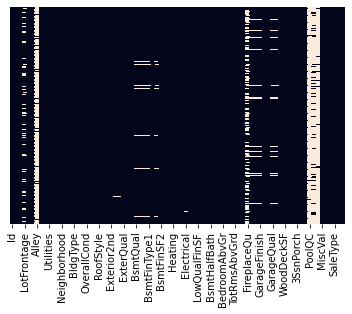

In [12]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
df.loc[:, df.isnull().any()].head()

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN


In [15]:
## Fill Missing Values - train data
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['MasVnrType']=df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])
df['BsmtQual']=df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
df['BsmtCond']=df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])
df['BsmtExposure']=df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
df['BsmtFinType2']=df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])
df['BsmtFinType1']=df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0])
df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])
df['FireplaceQu']=df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])
df['GarageType']=df['GarageType'].fillna(df['GarageType'].mode()[0])
df['GarageFinish']=df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])
df['GarageQual']=df['GarageQual'].fillna(df['GarageQual'].mode()[0])
df['GarageCond']=df['GarageCond'].fillna(df['GarageCond'].mode()[0])

df.drop(['Alley','GarageYrBlt','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
df.drop(['Id'],axis=1,inplace=True)
df.dropna(inplace=True)


In [16]:
df.loc[:, df.isnull().any()].sum()

Series([], dtype: float64)

In [17]:
#Handle categorical data
cat_columns=['MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
         'Condition2','BldgType','Condition1','HouseStyle','SaleType',
        'SaleCondition','ExterCond',
         'ExterQual','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
        'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Heating','HeatingQC',
         'CentralAir',
         'Electrical','KitchenQual','Functional',
         'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive']

In [18]:
len(cat_columns)

39

In [19]:
main_train_df=df.copy()

In [20]:
houses_df=pd.concat([df,test_df],axis=0)
houses_df.shape

(2919, 75)

In [21]:
print(f'df.shape = {df.shape}, test_df.shape = {test_df.shape}, final.shape{houses_df.shape}')

df.shape = (1460, 75), test_df.shape = (1459, 74), final.shape(2919, 75)


In [22]:
def onehot_encoding(final_df,cat_columns):
    encoded_df=final_df
    i=0
    for column in cat_columns:
        print(column)
        df1=pd.get_dummies(final_df[column],drop_first=True)
        final_df.drop([column],axis=1,inplace=True)
        if i==0:
             encoded_df=df1.copy()
        else:     
             encoded_df=pd.concat([ encoded_df,df1],axis=1)
        i=i+1
       
    encoded_df=pd.concat([final_df, encoded_df],axis=1)
        
    return encoded_df

In [23]:
houses_df=onehot_encoding(houses_df, cat_columns)

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition2
BldgType
Condition1
HouseStyle
SaleType
SaleCondition
ExterCond
ExterQual
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive


In [24]:
houses_df.shape #after applying onehot encoding

(2919, 236)

In [25]:
houses_df=houses_df.loc[:,~houses_df.columns.duplicated()] #Remove duplicated columns

In [26]:
houses_df.shape

(2919, 176)

In [27]:
houses_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,1,0,0,0,0,1,0


In [28]:
#train, test = train_test_split(houses_df, test_size=0.2)
train=houses_df.iloc[:1460,:] # #The number of observations in train data
test=houses_df.iloc[1460:,:]

In [29]:
X_train=train.drop(['SalePrice'],axis=1)
y_train=train['SalePrice']
X_test=test.drop(['SalePrice'],axis=1)
y_test=test['SalePrice']

In [30]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,1,0,0,0,0,1,0


[17:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


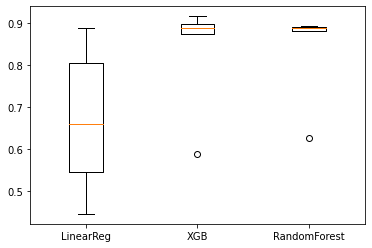

In [31]:
models = {"LinearReg":LinearRegression(),"XGB":xgboost.XGBRegressor(),"RandomForest":RandomForestRegressor() }
results = []
for model in models.values():
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  cv_results=cross_val_score(model,X_train,y_train,cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

In [32]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Applying Machine learning algos

In [33]:
#XGB
XGB_Regressor=xgboost.XGBRegressor()
XGB_Regressor.fit(X_train,y_train)
y_pred_xgb=XGB_Regressor.predict(X_test)
y_pred_xgb
#0.14054 scored on kaggle (without scaling)
#0.14054 scored on kaggle

[17:52:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([123579.086, 153624.25 , 179177.39 , ..., 165475.47 , 125263.01 ,
       240619.03 ], dtype=float32)

In [34]:
# Define the grid of hyperparameters to search
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.025,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
booster=['gbtree','gblinear']
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [35]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=XGB_Regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [36]:
random_cv.fit(X_train,y_train)
#0.13555 scored on kaggle

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[18:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.025, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [37]:
y_pred=random_cv.predict(X_test)

In [38]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(XGB_Regressor, open(filename, 'wb'))   

In [40]:
#Random Forest Regressor
RF_Regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
y_pred_RF = RF_Regressor.fit(X_train,y_train)
y_pred_RF = RF_Regressor.predict(X_test)
y_pred_RF
#0.14638 scored on kaggle

array([127616.5 , 155597.  , 178412.8 , ..., 150999.82, 113739.75,
       234803.  ])

In [41]:
# Linear Regression
LR_Regressor = LinearRegression()
y_pred_LR = LR_Regressor.fit(X_train, y_train)
y_pred_LR = LR_Regressor.predict(X_test)
y_pred_LR
#0.18916 scored on kaggle

array([128598.58908423, 170766.00542921, 185829.43276682, ...,
       174823.78584641, 102673.34091979, 238284.08883647])

In [42]:
# Initialising the Artifical Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu',input_dim = 175))

# Adding the second hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(50, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(1, kernel_initializer = 'he_uniform'))

# Compiling the ANN
classifier.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train, y_train,validation_split=0.30, batch_size = 10, epochs = 1500)

Epoch 1/1500
103/103 [==============================] - 3s 13ms/step - loss: 39388999680.0000 - val_loss: 38211440640.0000
Epoch 2/1500
103/103 [==============================] - 1s 10ms/step - loss: 39372439552.0000 - val_loss: 38183313408.0000
Epoch 3/1500
103/103 [==============================] - 1s 11ms/step - loss: 39312359424.0000 - val_loss: 38088941568.0000
Epoch 4/1500
103/103 [==============================] - 1s 12ms/step - loss: 39136206848.0000 - val_loss: 37837012992.0000
Epoch 5/1500
103/103 [==============================] - 1s 9ms/step - loss: 38768320512.0000 - val_loss: 37427732480.0000
Epoch 6/1500
103/103 [==============================] - 1s 7ms/step - loss: 38137831424.0000 - val_loss: 36561293312.0000
Epoch 7/1500
103/103 [==============================] - 0s 4ms/step - loss: 36949774336.0000 - val_loss: 35256995840.0000
Epoch 8/1500
103/103 [==============================] - 0s 3ms/step - loss: 35203633152.0000 - val_loss: 33288003584.0000
Epoch 9/1500
103/103

In [43]:
y_pred=classifier.predict(X_test)
#0.16689 - 0.18489(scaler)

46/46 [==============================] - 0s 2ms/step


In [44]:
pred_df=pd.DataFrame(y_pred) #Converting to DF
submission_df=pd.read_csv('/content/sample_submission.csv') #Reading website's sample as csv
datasets=pd.concat([submission_df['Id'],pred_df],axis=1) #Taking the ID from the submission after we deleted it at the beggning
datasets.columns=['Id','SalePrice']
datasets.to_csv('Seqential_submission.csv',index=False)